Lambda School Data Science, Unit 2: Predictive Modeling

# Kaggle Challenge, Module 4

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 60% accuracy (above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](https://towardsdatascience.com/maximizing-scarce-maintenance-resources-with-data-8f3491133050), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading
- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Simple guide to confusion matrix terminology](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/) by Kevin Markham, with video
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See below)
- [ ] Stacking Ensemble. (See below)
- [ ] More Categorical Encoding. (See below)

### RandomizedSearchCV / GridSearchCV, for model selection

- _[Introduction to Machine Learning with Python](http://shop.oreilly.com/product/0636920030515.do)_ discusses options for "Grid-Searching Which Model To Use" in Chapter 6:

> You can even go further in combining GridSearchCV and Pipeline: it is also possible to search over the actual steps being performed in the pipeline (say whether to use StandardScaler or MinMaxScaler). This leads to an even bigger search space and should be considered carefully. Trying all possible solutions is usually not a viable machine learning strategy. However, here is an example comparing a RandomForestClassifier and an SVC ...

The example is shown in [the accompanying notebook](https://github.com/amueller/introduction_to_ml_with_python/blob/master/06-algorithm-chains-and-pipelines.ipynb), code cells 35-37. Could you apply this concept to your own pipelines?

### Stacking Ensemble

Here's some code you can use to "stack" multiple submissions, which is another form of ensembling:

```python
import pandas as pd

# Filenames of your submissions you want to ensemble
files = ['submission-01.csv', 'submission-02.csv', 'submission-03.csv']

target = 'status_group'
submissions = (pd.read_csv(file)[[target]] for file in files)
ensemble = pd.concat(submissions, axis='columns')
majority_vote = ensemble.mode(axis='columns')[0]

sample_submission = pd.read_csv('sample_submission.csv')
submission = sample_submission.copy()
submission[target] = majority_vote
submission.to_csv('my-ultimate-ensemble-submission.csv', index=False)
```


### More Categorical Encodings

**1.** The article **[Categorical Features and Encoding in Decision Trees](https://medium.com/data-design/visiting-categorical-features-and-encoding-in-decision-trees-53400fa65931)** mentions 4 encodings:

- **"Categorical Encoding":** This means using the raw categorical values as-is, not encoded. Scikit-learn doesn't support this, but some tree algorithm implementations do. For example, [Catboost](https://catboost.ai/), or R's [rpart](https://cran.r-project.org/web/packages/rpart/index.html) package.
- **Numeric Encoding:** Synonymous with Label Encoding, or "Ordinal" Encoding with random order. We can use [category_encoders.OrdinalEncoder](https://contrib.scikit-learn.org/categorical-encoding/ordinal.html).
- **One-Hot Encoding:** We can use [category_encoders.OneHotEncoder](http://contrib.scikit-learn.org/categorical-encoding/onehot.html).
- **Binary Encoding:** We can use [category_encoders.BinaryEncoder](http://contrib.scikit-learn.org/categorical-encoding/binary.html).


**2.** The short video 
**[Coursera — How to Win a Data Science Competition: Learn from Top Kagglers — Concept of mean encoding](https://www.coursera.org/lecture/competitive-data-science/concept-of-mean-encoding-b5Gxv)** introduces an interesting idea: use both X _and_ y to encode categoricals.

Category Encoders has multiple implementations of this general concept:

- [CatBoost Encoder](http://contrib.scikit-learn.org/categorical-encoding/catboost.html)
- [James-Stein Encoder](http://contrib.scikit-learn.org/categorical-encoding/jamesstein.html)
- [Leave One Out](http://contrib.scikit-learn.org/categorical-encoding/leaveoneout.html)
- [M-estimate](http://contrib.scikit-learn.org/categorical-encoding/mestimate.html)
- [Target Encoder](http://contrib.scikit-learn.org/categorical-encoding/targetencoder.html)
- [Weight of Evidence](http://contrib.scikit-learn.org/categorical-encoding/woe.html)

Category Encoder's mean encoding implementations work for regression problems or binary classification problems. 

For multi-class classification problems, you will need to temporarily reformulate it as binary classification. For example:

```python
encoder = ce.TargetEncoder(min_samples_leaf=..., smoothing=...) # Both parameters > 1 to avoid overfitting
X_train_encoded = encoder.fit_transform(X_train, y_train=='functional')
X_val_encoded = encoder.transform(X_train, y_val=='functional')
```

**3.** The **[dirty_cat](https://dirty-cat.github.io/stable/)** library has a Target Encoder implementation that works with multi-class classification.

```python
 dirty_cat.TargetEncoder(clf_type='multiclass-clf')
```
It also implements an interesting idea called ["Similarity Encoder" for dirty categories](https://www.slideshare.net/GaelVaroquaux/machine-learning-on-non-curated-data-154905090).

However, it seems like dirty_cat doesn't handle missing values or unknown categories as well as category_encoders does. And you may need to use it with one column at a time, instead of with your whole dataframe.

**4. [Embeddings](https://www.kaggle.com/learn/embeddings)** can work well with sparse / high cardinality categoricals.

_**I hope it’s not too frustrating or confusing that there’s not one “canonical” way to encode categorcals. It’s an active area of research and experimentation! Maybe you can make your own contributions!**_

In [1]:
import os, sys
in_colab = 'google.colab' in sys.modules

# If you're in Colab...
if in_colab:
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge.git
    !git pull origin master
    
    # Install required python packages
    !pip install -r requirements.txt
    
    # Change into directory for module
    os.chdir('module4')

In [6]:
%matplotlib inline
import category_encoders as ce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier

# data wrangling
def wrangle(x):
    """wrangle trian, val, and test sets in the same way"""

    #   make copy
    x = x.copy()

    #   replace outliers with 0
    x['latitude'] = x['latitude'].replace(-2e-08, 0)

    #   replace 0's with np.nan
    cols_with_zeros = ['longitude', 'latitude', 'amount_tsh', 'construction_year', 'gps_height', 'population']
    for col in cols_with_zeros:
        x[col] = x[col].replace(0, np.nan)
        x[col+'_missing'] = x[col].isna()

    #   drop duplicate
    x = x.drop(columns=['quantity_group', 'payment_type'])

    #   to_datetime
    x['date_recorded'] = pd.to_datetime(x['date_recorded'], infer_datetime_format=True)

    #   extract components
    x['year_recorded'] = x['date_recorded'].dt.year
    x['month_recorded'] = x['date_recorded'].dt.month
    x['day_recorded'] = x['date_recorded'].dt.day

    x = x.drop(columns='date_recorded')

    #   Engineer feature: how many years from construction_year to date_recorded
    x['years'] = x['year_recorded'] - x['construction_year']
    x['years_MISSING'] = x['years'].isna()

    #   drop recorded_by and id 
    x = x.drop(columns=['recorded_by', 'id'])

    return x


# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv('../data/tanzania/train_features.csv'), 
                 pd.read_csv('../data/tanzania/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv('../data/tanzania/test_features.csv')
sample_submission = pd.read_csv('../data/tanzania/sample_submission.csv')

# train/ validation split
train, val = train_test_split(train,
                              test_size=0.25,
                              stratify=train['status_group'], 
                              random_state=0)

# apply wrangle() to all sets
train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

# features matrix and target vector
target = 'status_group'

x_train = train.drop(columns=target)
y_train = train[target]
x_val = val.drop(columns=target)
y_val = val[target]
x_test = test

# make pipeline and fit on train, score on valabs
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100,
                           random_state=0,
                           min_samples_split=9,
                           max_features='auto',
                           max_depth=35,
                           n_jobs=-1
    )
)

# Fit on train, score on val
pipeline.fit(x_train, y_train)

# y_pred

y_pred = pipeline.predict(x_val)

# print scores
print('Train Accuracy', pipeline.score(x_train, y_train))
print('Validation Accuracy', pipeline.score(x_val, y_val))

Train Accuracy 0.9286868686868687
Validation Accuracy 0.8164983164983165


In [7]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_val, y_pred)

array([[7348,  115,  602],
       [ 596,  327,  156],
       [1193,   63, 4450]])

In [8]:
# get labels
from sklearn.utils.multiclass import unique_labels
unique_labels(y_val)

array(['functional', 'functional needs repair', 'non functional'],
      dtype='<U23')

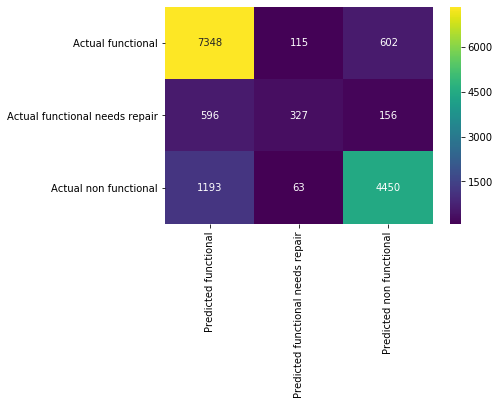

In [9]:
# plot a heatmap
def plot_confusion_matrix(y_true, y_pred):
    labels = unique_labels(y_true)
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}' for label in labels]
    table = pd.DataFrame(confusion_matrix(y_true, y_pred), 
                         columns=columns, index=index)
    return sns.heatmap(table, annot=True, fmt='d', cmap='viridis')
    
plot_confusion_matrix(y_val, y_pred);

In [10]:
# how many correct
7348 + 327 + 4450

12125

In [11]:
# how many total predictions made
7348 + 115 + 602 + 596 + 327 + 156 + 1193 + 63 + 4450

14850

In [12]:
correct_predictions = 12125
total_predictions = 14850
correct_predictions / total_predictions

0.8164983164983165

In [13]:
# precision and recall
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))

                         precision    recall  f1-score   support

             functional       0.80      0.91      0.85      8065
functional needs repair       0.65      0.30      0.41      1079
         non functional       0.85      0.78      0.82      5706

               accuracy                           0.82     14850
              macro avg       0.77      0.66      0.69     14850
           weighted avg       0.81      0.82      0.81     14850

